# Random Forest

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

### Load dataset

In [3]:
column_names = ['Attr.1', 'Attr.2', 'Attr.3', 'Attr.4', 'label']
data = pd.read_csv('iris.data',names=column_names, header=None)
data.head(5)

,Attr.1,Attr.2,Attr.3,Attr.4,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Dataset info.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
Attr.1    150 non-null float64
Attr.2    150 non-null float64
Attr.3    150 non-null float64
Attr.4    150 non-null float64
label     150 non-null object
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
data.describe()

,Attr.1,Attr.2,Attr.3,Attr.4
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
data.groupby('label').size()

label
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

## DecisionTree

Copy from last experiment with a little modification.

In [52]:
class DecisionTree:
    
    def __init__(self, criteria='Entropy', attr_perturb=False, m = 4):
        self.criteria = criteria
        self.attr_perturb = attr_perturb
        self.m = m
        self.tree = None
        if criteria == 'Entropy':
            self.gain_function = self._entropy_gain
            self.cal_criterion_after_split = self._cal_entropy_after_split
        elif criteria == 'minError':
            self.gain_function = self._error_gain
            self.cal_criterion_after_split = self._cal_error_after_split
        elif criteria == 'Gini':
            self.gain_function = self._gini_gain
            self.cal_criterion_after_split = self._cal_gini_after_split
            
            
    def make_tree(self, data, max_depth=8):
        self.tree = self._make_tree(data, max_depth=max_depth)
        
    
    def predict(self, sample):
        return self._predict(sample, self.tree)
    
    
    def evaluate(self, data):
        return self._evaluate(data, self.tree);
    
    
    def _split_data(self, data, frac):
        data = data.sample(frac=1)
        train_set = data.iloc[(int)(len(data) * frac) : , : ]
        evaluate_set = data.iloc[0 : (int)(len(data) * frac), : ]
        return train_set, evaluate_set
        
        
    def _predict(self, sample, tree):
        if not isinstance(tree, dict):
            return tree

        attr, split_point = list(tree.keys())[0].split('<=')
        split_point = (float)(split_point)
        if sample[attr] <= split_point:
            return self._predict(sample, tree[list(tree.keys())[0]])
        else:
            return self._predict(sample, tree[list(tree.keys())[1]])
        
        
    def _evaluate(self, data, tree):
        if len(data) == 0:
            return 1
        
        right_count = 0
        for _, sample in data.T.iteritems():
            label = sample[-1]
            if label == self._predict(sample, tree):
                right_count += 1
        return right_count / len(data)

            
    def _make_tree(self, train_set, max_depth=8):
        attr_name_list = train_set.columns[:-1]
        label_name = train_set.groupby('label').size().index
        if max_depth == 0:
            label, precise = self._get_max_precise(train_set)
            return label
        
        if len(label_name) == 0:
            return ''
        
        if len(label_name) == 1:
            return label_name[0]
        
        best_attr = self._find_best_attribute(train_set, self.gain_function)
        split_point = self._find_best_split_point(train_set, best_attr, self.cal_criterion_after_split)
        
        if len(train_set.groupby(best_attr).size()) == 1:
            label, precise = self._get_max_precise(train_set)
            return label
        tree = {}
        tree['%s<=%f' % (best_attr, split_point)] = \
                        self._make_tree(train_set[train_set[best_attr] <= split_point], max_depth - 1)
        tree['%s>%f' % (best_attr, split_point)] = \
                        self._make_tree(train_set[train_set[best_attr] >  split_point], max_depth - 1)
        return tree

        
    def _find_best_split_point(self, data, attr_name, criterion_function):
        fhi = 0.618
        f = criterion_function
        a = min(data[attr_name])
        b = max(data[attr_name])
        mu = a + (1 - fhi) * (b - a)
        lamb = a + fhi * (b - a)
        f_mu = f(data, attr_name, mu)
        f_lambda = f(data, attr_name, lamb)

        while(f_mu != f_lambda):
            if f_mu > f_lambda:
                a = mu
                mu = lamb
                lamb = a + fhi * (b - a)
                f_mu = f_lambda
                f_lambda = f(data, attr_name, lamb)
            else:
                b = lamb
                lamb = mu
                mu = a + (1 - fhi) * (b - a)
                f_lambda = f_mu
                f_mu = f(data, attr_name, mu)
        split_point = (mu + lamb) / 2
        return split_point
        
        
    def _find_best_attribute(self, data, gain_function):
        gain = gain_function
        attr_name_list = list(data.columns[:-1])
        
        if self.attr_perturb:
            np.random.shuffle(attr_name_list)
            attr_name_list = attr_name_list[ : self.m]

        best_attr = attr_name_list[0];
        max_gain = gain(data, best_attr)
        for attr in attr_name_list:
            g = gain(data, attr)
            if max_gain < g:
                best_attr = attr
                max_gain = g
        return best_attr

    
    def _get_max_precise(self, data):
        precise_dict = dict(data.groupby('label').size() / len(data))
        if len(precise_dict) == 0:
            return '', 0
        else:
            label = max(precise_dict, key = precise_dict.get)
            precise = precise_dict[label]
            return label, precise
    
    
    def _get_max_precise_after_split(self, data, attr, split_point):
        if len(data) == 0:
            return 0
        data_1 = data[data[attr] <= split_point]
        data_2 = data[data[attr] >  split_point]
        _, precise_1 = self._get_max_precise(data_1)
        _, precise_2 = self._get_max_precise(data_2)
        precise = len(data_1) / len(data) * precise_1 + len(data_2) / len(data) * precise_2
        return precise
        
        
    def _cal_entropy(self, data):
        p = data.groupby('label').size() / len(data)
        h = -sum(p * np.log(p))
        return h
    
    
    def _cal_entropy_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        h_1 = self._cal_entropy(d_1)
        h_2 = self._cal_entropy(d_2)
        h = len(d_1) / len(data) * h_1 + len(d_2) / len(data) * h_2
        return h
    
    
    def _entropy_gain(self, data, attr):
        old_entropy = self._cal_entropy(data);
        split_point = self._find_best_split_point(data, attr, 
                                            self._cal_entropy_after_split)
        new_entropy = self._cal_entropy_after_split(data, attr, split_point)
        gain = old_entropy - new_entropy
        return gain
    
    
    def _cal_error(self, data):
        _, precise = self._get_max_precise(data)
        error = 1 - precise
        return error
    
    
    def _cal_error_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        error_1 = self._cal_error(d_1)
        error_2 = self._cal_error(d_2)
        error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
        return error
    
    def _error_gain(self, data, attr):
        old_error = self._cal_error(data);
        split_point = self._find_best_split_point(data, attr, 
                                                  self._cal_error_after_split)
        new_error = self._cal_error_after_split(data, attr, split_point)
        gain = old_error - new_error
        return gain
    
    
    def _cal_gini(self, data):
        p = data.groupby('label').size() / len(data)
        gini = 1 - np.sum(np.power(p, 2))
        return gini
    
    
    def _cal_gini_after_split(self, data, attr_name, split_point):
        d_1 = data[data[attr_name] <= split_point]
        d_2 = data[data[attr_name] >  split_point]
        error_1 = self._cal_error(d_1)
        error_2 = self._cal_error(d_2)
        error = len(d_1) / len(data) * error_1 + len(d_2) / len(data) * error_2
        return error
    
    
    def _gini_gain(self, data, attr):
        old_error = self._cal_gini(data);
        split_point = self._find_best_split_point(data, attr, 
                                                  self._cal_gini_after_split)
        new_error = self._cal_gini_after_split(data, attr, split_point)
        gain = old_error - new_error
        return gain

### test if works

In [61]:
tree = DecisionTree(attr_perturb=True, m=1)
tree.make_tree(data.sample(frac=1, replace=True))
tree.evaluate(data)

0.9533333333333334

## OOB(Out-Of-Bag) error estimate

**Procedure**
1. Put each case left out in the construction of the kth tree(about one-third of the trees) down the kth tree to get a classification. 
2. Take j to be the class that got most of the votes every time case n was oob.
3. The proportion of times that j is not equal to the true class of n averaged over all cases is the oob error estimate.

Copy from https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

In [62]:
train_set_1 = data.sample(frac=1, replace=True)
train_set_2 = data.sample(frac=1, replace=True)
train_set_3 = data.sample(frac=1, replace=True)
tree_1 = DecisionTree()
tree_1.make_tree(train_set_1)
tree_2 = DecisionTree()
tree_2.make_tree(train_set_2)
tree_3 = DecisionTree()
tree_3.make_tree(train_set_3)

In [109]:
train_sets = [train_set_1, train_set_2, train_set_3]
forest = [tree_1, tree_2, tree_3]

In [121]:
right = 0
wrong = 0
tree_num = len(forest)
for i in range(len(data)):
    predict_results = {}
    for tree, train_set in zip(forest, train_sets):
        if i not in train_set.index:
            predict_result = tree.predict(data.loc[i, :])
            if predict_result not in predict_results.keys():
                predict_results[predict_result] = 1
            else:
                predict_results[predict_result] += 1
    if predict_results == {}:
        # sample in all tree's train set
        right += 1
    else:
        predict_result = max(predict_results, key=predict_results.get)
        if predict_result == data.loc[i,:][-1]:
            right += 1
        else:
            wrong += 1
ER = wrong / (right + wrong)
print('error rate: %.3f' % ER)

error rate: 0.053


## Correlation between trees

**Kohavi-Wolpert variance**

$$
KW = \frac{1}{NL^2} \sum_{i=1}^N{l_i(L-l_i)}
$$ 

- $L$: total number of base classifiers
- $N$: total number of training samples
- $l_i$: number of base classifiers that classify the training sample ${\rm \bf{x}}_i$ incorrestly

**Reference**:

Tang E K , Suganthan P N , Yao X . An analysis of diversity measures[J]. Machine Learning, 2006, 65(1):247-271.
https://link.springer.com/content/pdf/10.1007%2Fs10994-006-9449-2.pdf

In [123]:
L = len(forest)
N = len(data)
KW = 0
for i in range(N):
    l = 0
    for tree in forest:
        predict_result = tree.predict(data.loc[i, :])
        if predict_result != data.loc[i, :][-1]:
            l += 1
    KW += l * (L - l)
KW /= (N * L**2)
KW

0.011851851851851851

## Random Forest

In [146]:
class RandomForest:
    
    def __init__(self, trees_num=4, attr_perturb=False, m=4, criteria_perturb=False):
        self.trees_num = trees_num
        self.attr_perturb = attr_perturb
        self.m = m
        self.criteria_perturb = criteria_perturb
        self.forest = []
        self.criteria = ['Entropy', 'minError', 'Gini']
        for i in range(self.trees_num):
            if self.criteria_perturb:
                criterion = self.criteria[np.random.randint(3)]
            else:
                criterion = self.criteria[0]
                
            tree = DecisionTree(attr_perturb=self.attr_perturb,
                                    m=self.m, criteria=criterion)
            self.forest.append(tree)
            
    
    def make_forest(self, data):
        self.train_sets = []
        for tree in self.forest:
            train_set = data.sample(frac=1, replace=True)
            self.train_sets.append(train_set)
            tree.make_tree(train_set)
            
    
    def predict(self, data):
        predict_results = {}
        for tree in self.forest:
            predict_result = tree.predict(data)
            if predict_result not in predict_results.keys():
                predict_results[predict_result] = 1
            else:
                predict_results[predict_result] += 1
        predict_result = max(predict_results, key=predict_results.get)
        return predict_result
    
    
    def evaluate(self, data):
        right_count = 0
        for i in range(len(data)):
            predict_result = self.predict(data.loc[i, :])
            if predict_result == data.loc[i, :][-1]:
                right_count += 1
        precise = right_count / len(data)
        return precise
            
    
    def OOBEstimate(self, data):
        right = 0
        wrong = 0
        for i in range(len(data)):
            predict_results = {}
            for tree, train_set in zip(self.forest, self.train_sets):
                if i not in train_set.index:
                    predict_result = tree.predict(data.loc[i, :])
                    if predict_result not in predict_results.keys():
                        predict_results[predict_result] = 1
                    else:
                        predict_results[predict_result] += 1
            if predict_results == {}:
                # sample in all tree's train set
                right += 1
            else:
                predict_result = max(predict_results, key=predict_results.get)
                if predict_result == data.loc[i,:][-1]:
                    right += 1
                else:
                    wrong += 1
        error_rate =  wrong / (right + wrong)
        return error_rate
    
    
    def KWcorrelation(self, data):
        L = self.trees_num
        N = len(data)
        KW = 0
        for i in range(N):
            l = 0
            for tree in self.forest:
                predict_result = tree.predict(data.loc[i, :])
                if predict_result != data.loc[i, :][-1]:
                    l += 1
            if L == 1:
                KW += 1
            else:
                KW += l * (L - l)
        KW /= (N * L**2)
        return KW

In [147]:
random_forest = RandomForest(trees_num=1)
random_forest.make_forest(data)

In [148]:
random_forest.KWcorrelation(data)

1.0

In [149]:
random_forest.OOBEstimate(data)

0.03333333333333333

In [150]:
random_forest.evaluate(data)

0.9666666666666667

## Evaluate RandomForest

### How many forest's size should be?

In [156]:
correlation_by_size = []
oobestimate_by_size = []
precise_by_size = []
max_size = 30
for s in range(1, max_size + 1):
    random_forest = RandomForest(trees_num=s)
    random_forest.make_forest(data)
    correlation = random_forest.KWcorrelation(data)
    estimation = random_forest.OOBEstimate(data)
    precise = random_forest.evaluate(data)
    correlation_by_size.append(correlation)
    oobestimate_by_size.append(estimation)
    precise_by_size.append(precise)

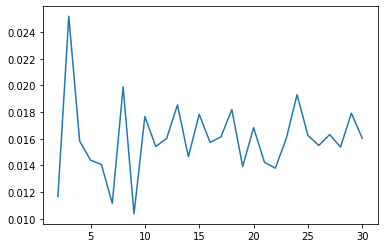

In [157]:
x = list(range(1, max_size + 1))
plt.plot(x[1:], correlation_by_size[1:])

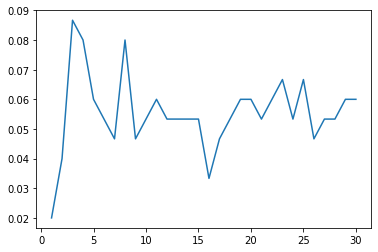

In [158]:
x = list(range(1, max_size + 1))
plt.plot(x, oobestimate_by_size)

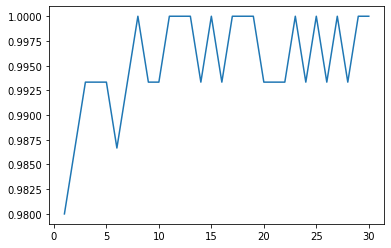

In [159]:
x = list(range(1, max_size + 1))
plt.plot(x, precise_by_size)

### How many m should be?

In [160]:
correlation_by_m = {}
oobestimate_by_m = {}
precise_by_m = {}
max_size = 15
for m in range(1, 5):
    correlation_by_size = []
    oobestimate_by_size = []
    precise_by_size = []
    for s in range(1, max_size + 1):
        print('[%d/%d,%d/%d]' % (m, 4, s, max_size))
        random_forest = RandomForest(trees_num=s)
        random_forest.make_forest(data)
        correlation = random_forest.KWcorrelation(data)
        estimation = random_forest.OOBEstimate(data)
        precise = random_forest.evaluate(data)
        correlation_by_size.append(correlation)
        oobestimate_by_size.append(estimation)
        precise_by_size.append(precise)
    correlation_by_m[m] = correlation_by_size
    oobestimate_by_m[m] = oobestimate_by_size
    precise_by_m[m] = precise_by_size

[1/4,1/15]
[1/4,2/15]
[1/4,3/15]
[1/4,4/15]
[1/4,5/15]
[1/4,6/15]
[1/4,7/15]
[1/4,8/15]
[1/4,9/15]
[1/4,10/15]
[1/4,11/15]
[1/4,12/15]
[1/4,13/15]
[1/4,14/15]
[1/4,15/15]
[2/4,1/15]
[2/4,2/15]
[2/4,3/15]
[2/4,4/15]
[2/4,5/15]
[2/4,6/15]
[2/4,7/15]
[2/4,8/15]
[2/4,9/15]
[2/4,10/15]
[2/4,11/15]
[2/4,12/15]
[2/4,13/15]
[2/4,14/15]
[2/4,15/15]
[3/4,1/15]
[3/4,2/15]
[3/4,3/15]
[3/4,4/15]
[3/4,5/15]
[3/4,6/15]
[3/4,7/15]
[3/4,8/15]
[3/4,9/15]
[3/4,10/15]
[3/4,11/15]
[3/4,12/15]
[3/4,13/15]
[3/4,14/15]
[3/4,15/15]
[4/4,1/15]
[4/4,2/15]
[4/4,3/15]
[4/4,4/15]
[4/4,5/15]
[4/4,6/15]
[4/4,7/15]
[4/4,8/15]
[4/4,9/15]
[4/4,10/15]
[4/4,11/15]
[4/4,12/15]
[4/4,13/15]
[4/4,14/15]
[4/4,15/15]


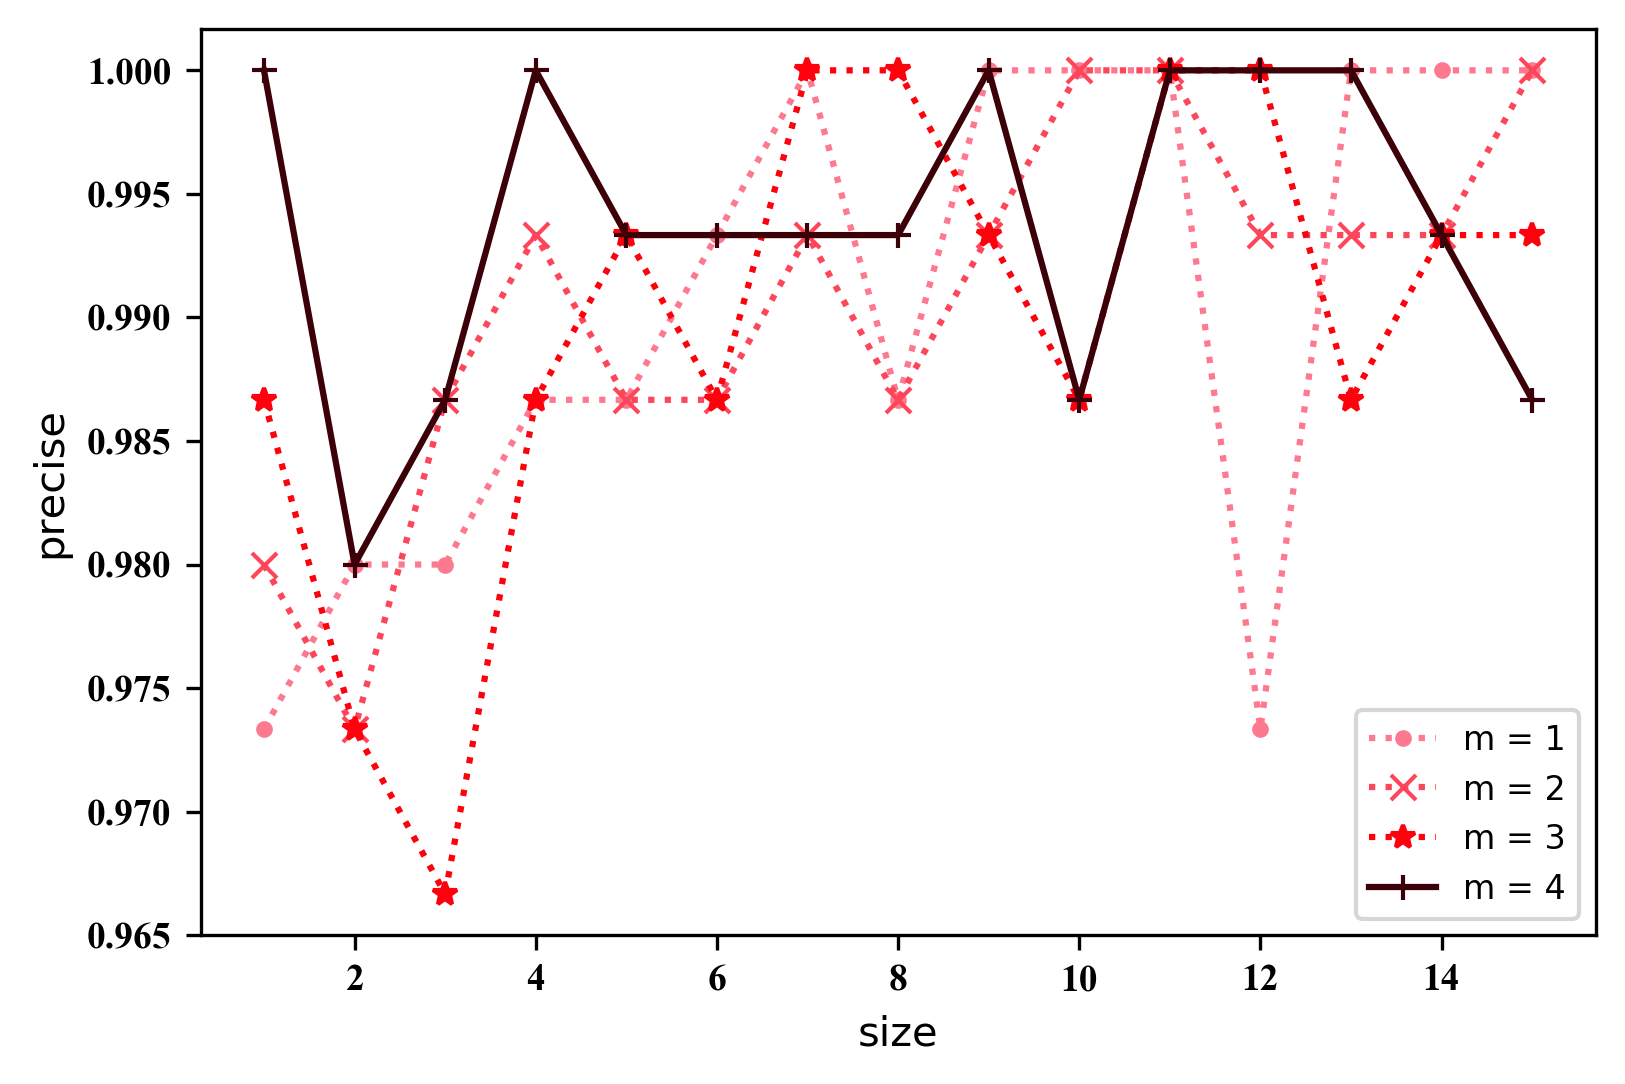

In [200]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

x = range(1, max_size + 1)

colors = ['#fd798f', '#fd4659', '#ff000d', '#3c0008']
markers = ['.', 'x', '*', '+']
style = [':', ':', ':', '-']
for m in range(1, 5):
    plt.plot(x, precise_by_m[m], color=colors[m-1],
             marker=markers[m - 1], linestyle=style[m-1],  label='m = %d' % m)

plt.xlabel('size')
plt.ylabel('precise')
plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
#plt.savefig('./precise_by_m_size.jpg', bbox_inches = 'tight')
#plt.savefig('./precise_by_m_size.eps', dpi=300, format='eps', bbox_inches = 'tight')
plt.show()

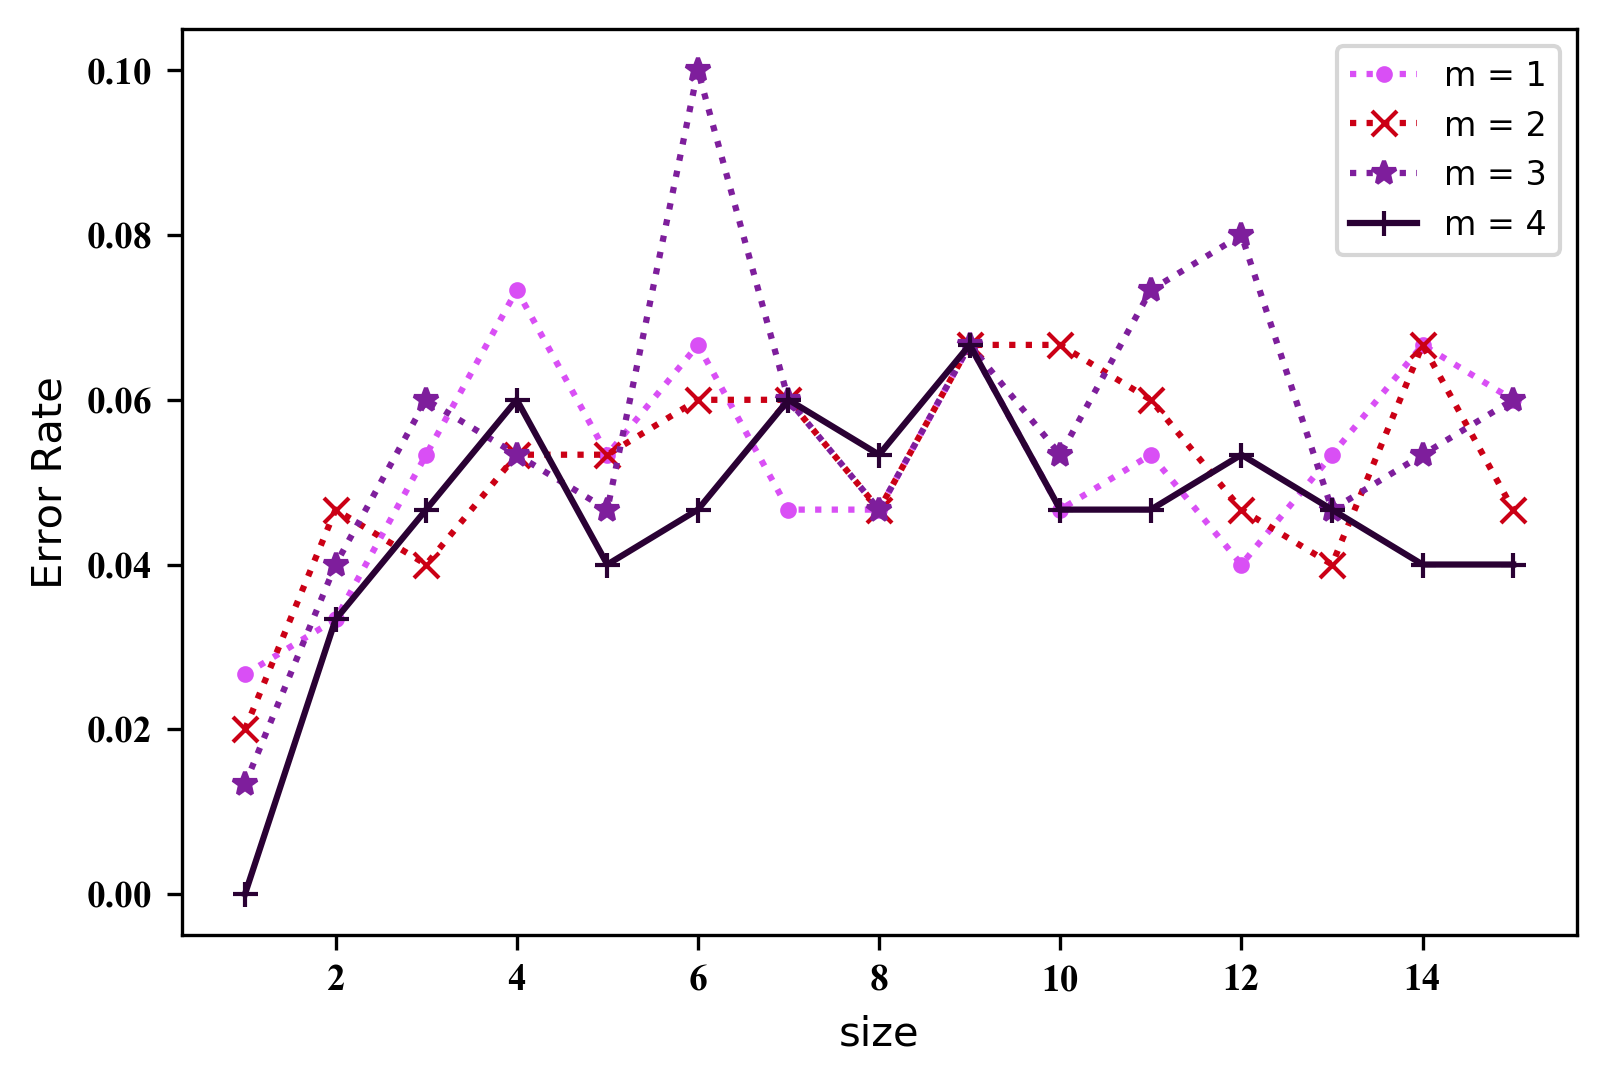

In [198]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

x = range(1, max_size + 1)

colors = ['#d94ff5', '#cb0015', '#7e1e9c', '#2a0134']
markers = ['.', 'x', '*', '+']
style = [':', ':', ':', '-']
for m in range(1, 5):
    plt.plot(x, oobestimate_by_m[m], color=colors[m-1],
             marker=markers[m-1], linestyle=style[m-1], label='m = %d' % m)

plt.xlabel('size')
plt.ylabel('Error Rate')
plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
#plt.savefig('./error_rate_by_m_size.jpg', bbox_inches = 'tight')
#plt.savefig('./error_rate_by_m_size.eps', dpi=300, format='eps', bbox_inches = 'tight')
plt.show()

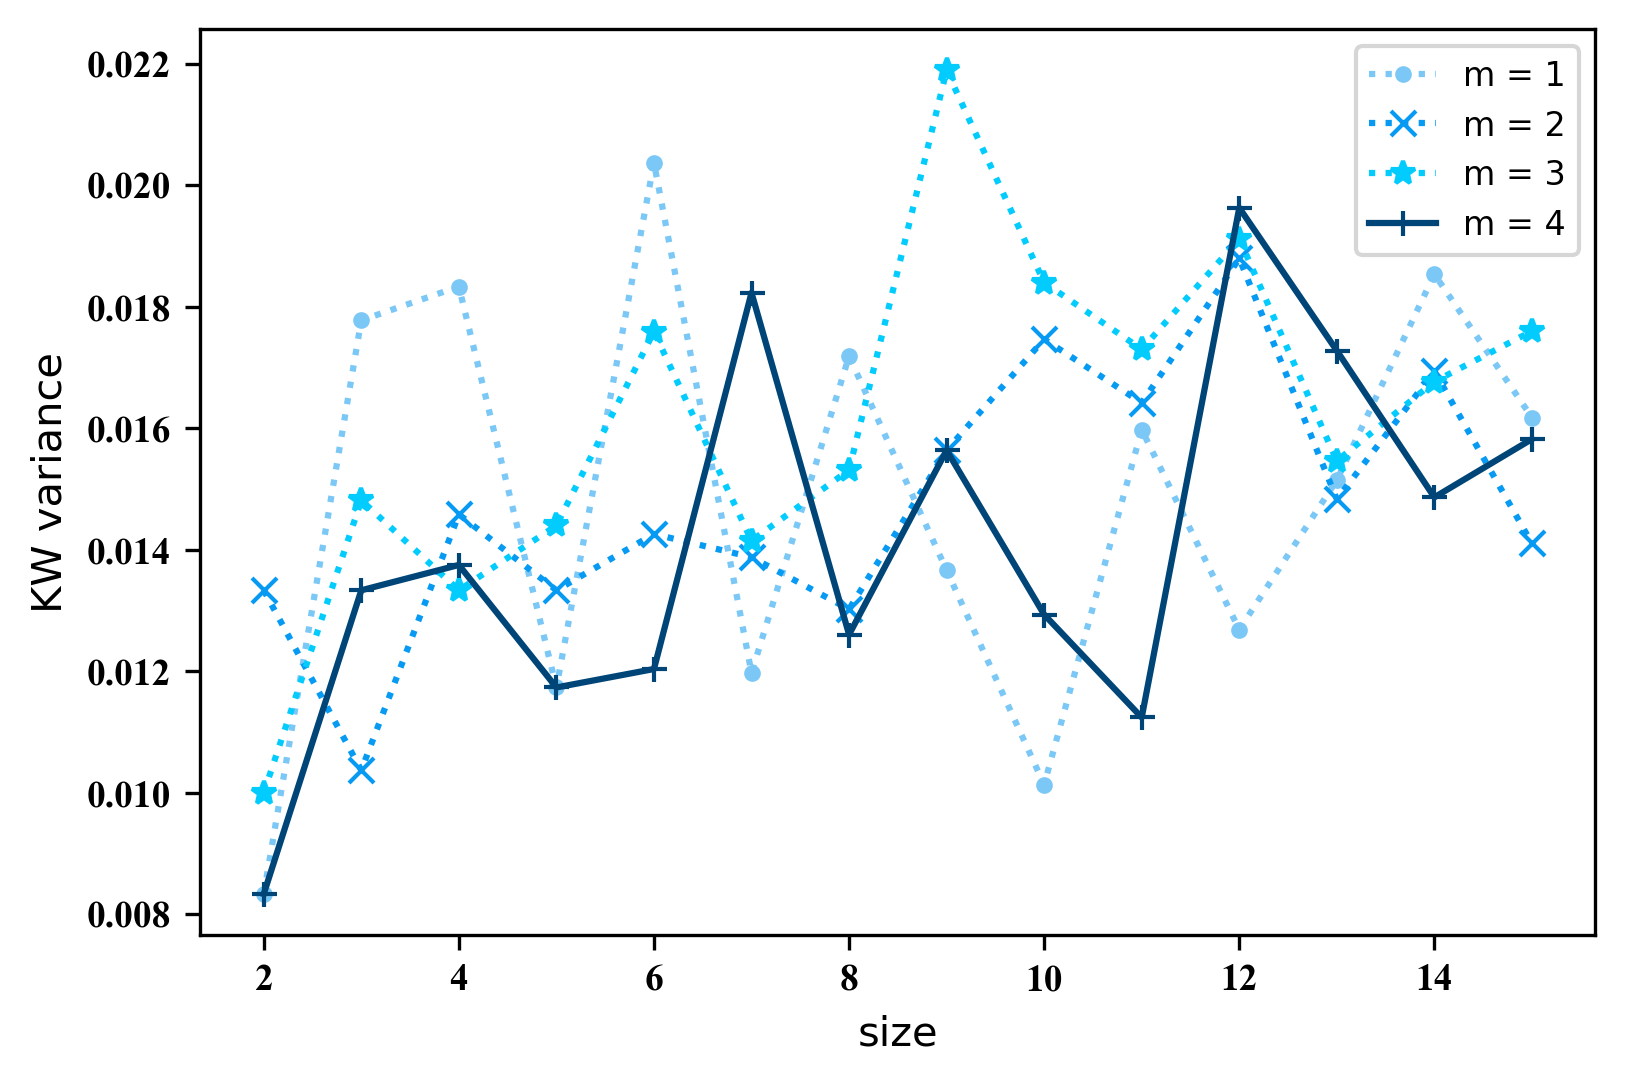

In [196]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

x = range(1, max_size + 1)

colors = ['#7bc8f6', '#069af3', '#02ccfe', '#004577']
markers = ['.', 'x', '*', '+']
style = [':', ':', ':', '-']
for m in range(1, 5):
    plt.plot(x[1:], correlation_by_m[m][1:], color=colors[m-1],
             marker=markers[m-1], linestyle=style[m-1], label='m = %d' % m)

plt.xlabel('size')
plt.ylabel('KW variance')
plt.yticks(fontproperties = 'Times New Roman', size = 9)
plt.xticks(fontproperties = 'Times New Roman', size = 9)
plt.legend(fontsize=8)
#plt.savefig('./corelation_by_m_size.jpg', bbox_inches = 'tight')
#plt.savefig('./corelation_by_m_size.eps', dpi=300, format='eps', bbox_inches = 'tight')
plt.show()

In [213]:
SIZE = 5

**Single tree**

In [218]:
random_forest = RandomForest(trees_num=1)
random_forest.make_forest(data)
correlation = random_forest.KWcorrelation(data)
estimation = random_forest.OOBEstimate(data)
precise = random_forest.evaluate(data)
print("correlation: %f" % correlation)
print("error rate: %f" % estimation)
print("precise: %f" % precise)

correlation: 1.000000
error rate: 0.026667
precise: 0.973333


**Sample perturbation**

In [214]:
random_forest = RandomForest(trees_num=SIZE)
random_forest.make_forest(data)
correlation = random_forest.KWcorrelation(data)
estimation = random_forest.OOBEstimate(data)
precise = random_forest.evaluate(data)
print("correlation: %f" % correlation)
print("error rate: %f" % estimation)
print("precise: %f" % precise)

correlation: 0.013867
error rate: 0.040000
precise: 1.000000


**Attribute perturbation**

In [215]:
random_forest = RandomForest(trees_num=SIZE, attr_perturb=True, m=3)
random_forest.make_forest(data)
correlation = random_forest.KWcorrelation(data)
estimation = random_forest.OOBEstimate(data)
precise = random_forest.evaluate(data)
print("correlation: %f" % correlation)
print("error rate: %f" % estimation)
print("precise: %f" % precise)

correlation: 0.011200
error rate: 0.046667
precise: 0.986667


**Criteria perturbation**

In [216]:
random_forest = RandomForest(trees_num=SIZE, criteria_perturb=True)
random_forest.make_forest(data)
correlation = random_forest.KWcorrelation(data)
estimation = random_forest.OOBEstimate(data)
precise = random_forest.evaluate(data)
print("correlation: %f" % correlation)
print("error rate: %f" % estimation)
print("precise: %f" % precise)

correlation: 0.021867
error rate: 0.080000
precise: 1.000000


**All perturbation**

In [217]:
random_forest = RandomForest(trees_num=SIZE, 
                             criteria_perturb=True,  attr_perturb=True, m=3)
random_forest.make_forest(data)
correlation = random_forest.KWcorrelation(data)
estimation = random_forest.OOBEstimate(data)
precise = random_forest.evaluate(data)
print("correlation: %f" % correlation)
print("error rate: %f" % estimation)
print("precise: %f" % precise)

correlation: 0.012267
error rate: 0.046667
precise: 0.993333
